In [1]:
%load_ext autoreload
%autoreload 2
!hostname
!pwd
import os, sys
print(sys.executable)
# os.environ['CUDA_VISIBLE_DEVICES'] = "7"
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = "false"
# sys.path.append(os.path.abspath(".."))

slurm0-gpu1nodeset-0
/home/akarsh_sakana_ai/spaghetti/src
/home/akarsh_sakana_ai/.conda/envs/spaghetti/bin/python


In [2]:
import os, sys, glob, pickle, copy, time
from functools import partial

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
# plt.rcParams['figure.figsize'] = (15, 5)
import seaborn as sns
sns.set_theme()

from tqdm.auto import tqdm
from einops import rearrange, reduce, repeat
from einop import einop

import jax
import jax.numpy as jnp
from jax.random import split

import flax
import flax.linen as nn
from flax.training.train_state import TrainState

import optax

In [3]:
from clip import CLIP
from cppn import CPPN, FlattenCPPNParameters
import util

In [4]:
target_img = plt.imread("../skull.jpg")/255.
print(target_img.shape)

(256, 256, 3)


Text(0.5, 1.0, 'Horizontally Flipped')

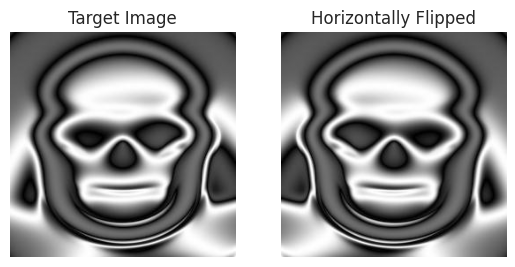

In [5]:
plt.subplot(121); plt.imshow(target_img); plt.axis("off"); plt.title("Target Image")
plt.subplot(122); plt.imshow(target_img[:, ::-1]); plt.axis("off"); plt.title("Horizontally Flipped")

In [6]:
from cppn import CPPN, FlattenCPPNParameters
def hsv2rgb(h, s, v):
    h = h * 360.

    c = v * s
    x = c * (1 - jnp.abs((h / 60) % 2 - 1))
    m = v - c

    r1, g1, b1, c1 = c, x, 0, (0 <= h)*(h<60)
    r2, g2, b2, c2 = x, c, 0, (60 <= h)*(h<120)
    r3, g3, b3, c3 = 0, c, x, (120 <= h)*(h<180)
    r4, g4, b4, c4 = 0, x, c, (180 <= h)*(h<240)
    r5, g5, b5, c5 = x, 0, c, (240 <= h)*(h<300)
    r6, g6, b6, c6 = c, 0, x, (300 <= h)*(h<360)

    r = r1 * c1 + r2 * c2 + r3 * c3 + r4 * c4 + r5 * c5 + r6 * c6
    g = g1 * c1 + g2 * c2 + g3 * c3 + g4 * c4 + g5 * c5 + g6 * c6
    b = b1 * c1 + b2 * c2 + b3 * c3 + b4 * c4 + b5 * c5 + b6 * c6
    r, g, b = r + m, g + m, b + m
    return r.clip(0., 1.), g.clip(0., 1.), b.clip(0., 1.)

class CPPN(nn.Module):
    n_layers: int
    d_hidden: int
    nonlin: str = 'tanh' # use tanh or relu
    hsv: bool = True

    @nn.compact
    def __call__(self, x):
        intermediate_features = [x]
        for i_layer in range(self.n_layers):
            x = nn.Dense(self.d_hidden)(x)
            x = getattr(nn, self.nonlin)(x)
            intermediate_features.append(x)
        x = nn.Dense(3)(x)
        intermediate_features.append(x)
        rgb = jax.nn.tanh(x) # CHANGED THIS TO TANH
        return rgb, intermediate_features

    def generate_image(self, params, img_size=128, intermediate_features=False):
        x = y = jnp.linspace(-1, 1, img_size)
        x, y = jnp.meshgrid(x, y, indexing='ij')
        d = jnp.sqrt(x**2 + y**2)
        xabs = jnp.abs(x)
        yabs = jnp.abs(y)
        # xyd = jnp.stack([x, y, d], axis=-1)
        xyd = jnp.stack([x, y, d, xabs, yabs], axis=-1)
        hsv, features = jax.vmap(jax.vmap(partial(self.apply, params)))(xyd)
        h,s,v = hsv[...,0], hsv[...,1], hsv[...,2]
        r, g, b = hsv2rgb((h+1)%1, s.clip(0,1), jnp.abs(v).clip(0, 1))
        rgb = jnp.stack([r, g, b], axis=-1)
        if intermediate_features:
            return rgb, features
        else:
            return rgb
import evosax
class FlattenCPPNParameters():
    def __init__(self, cppn):
        self.cppn = cppn

        rng = jax.random.PRNGKey(0)
        self.param_reshaper = evosax.ParameterReshaper(self.cppn.init(rng, jnp.zeros((5,))))
        self.n_params = self.param_reshaper.total_params
    
    def init(self, rng, x):
        params = self.cppn.init(rng, x)
        return self.param_reshaper.flatten_single(params)

    def generate_image(self, params, img_size=128, intermediate_features=False):
        params = self.param_reshaper.reshape_single(params)
        return self.cppn.generate_image(params, img_size=img_size, intermediate_features=intermediate_features)
    

In [7]:
cppn = CPPN(4, 50, nonlin='relu', hsv=True)
cppn = FlattenCPPNParameters(cppn)

rng = jax.random.PRNGKey(0)
params_sgd = cppn.init(rng, jnp.zeros((5,)))
# params_sgd = jax.random.normal(rng, (cppn.n_params,))

def loss_fn(params, target_img):
    img = cppn.generate_image(params, img_size=256)
    return jnp.mean((img - target_img)**2)

@jax.jit
def train_step(state, _):
    img = cppn.generate_image(state.params)
    loss, grad = jax.value_and_grad(loss_fn)(state.params, target_img)
    state = state.apply_gradients(grads=grad)
    return state, loss

tx = optax.adam(learning_rate=3e-4)
state = TrainState.create(apply_fn=None, params=params_sgd, tx=tx)

losses = []
for t in tqdm(range(500000)):
    state, loss = train_step(state, None)
    # state, loss = jax.lax.scan(train_step, state, None, length=1000)
    losses.append(loss)
losses = np.array(jnp.stack(losses))

params_sgd = state.params

plt.plot(losses)
plt.yscale("log")
plt.show()


ParameterReshaper: 8103 parameters detected for optimization.


  0%|          | 0/500000 [00:00<?, ?it/s]

KeyboardInterrupt: 

loss:  0.0021459325


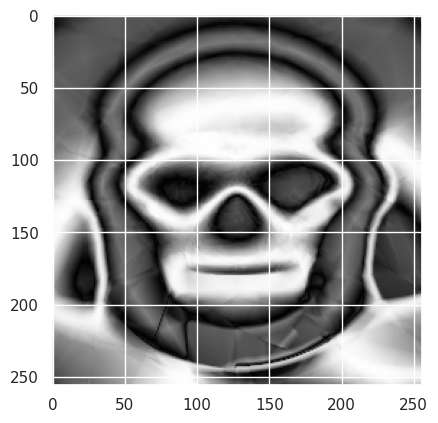

In [41]:
img = cppn.generate_image(params_sgd, img_size=256)
print("loss: ", ((img-target_img)**2).mean())
plt.imshow(img)

In [ ]:
gen_fn = jax.jit(jax.vmap(cppn.generate_image))
variances = []
for weight_id in tqdm(range(len(params_sgd))):
    weight_vals = jnp.linspace(-5, 5, 25)
    params = jnp.stack([params_sgd.at[weight_id].set(w) for w in weight_vals], axis=0)
    imgs = gen_fn(params)
    variance = jnp.var(imgs, axis=0).mean()
    variances.append(variance)
variances = jnp.array(variances)

  0%|          | 0/8103 [00:00<?, ?it/s]

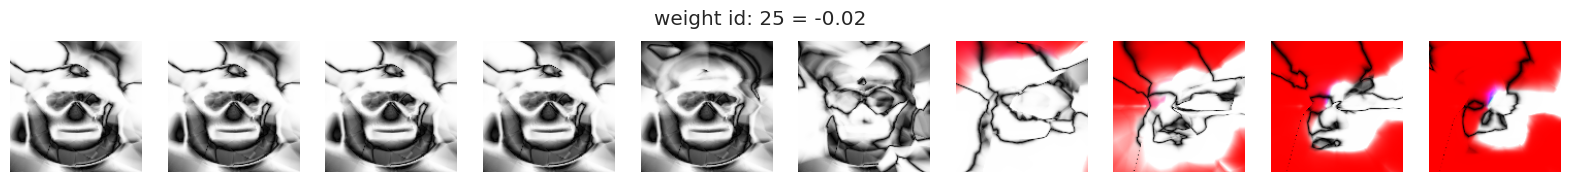

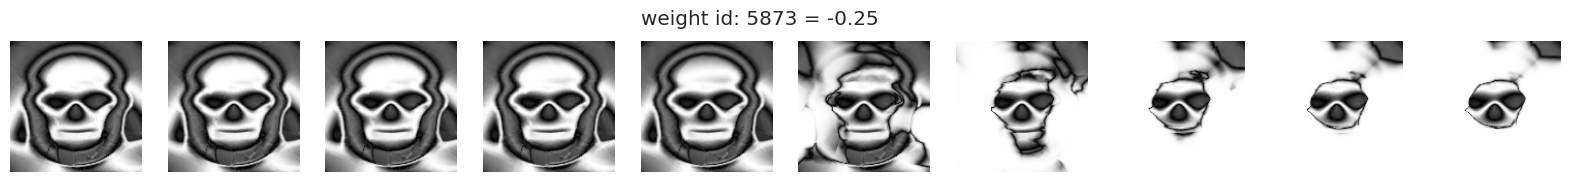

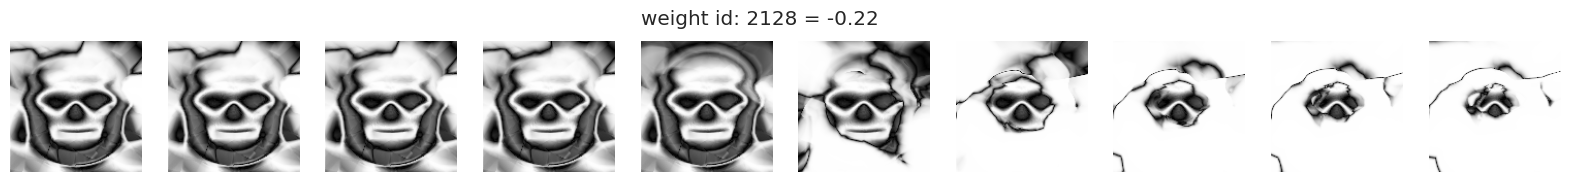

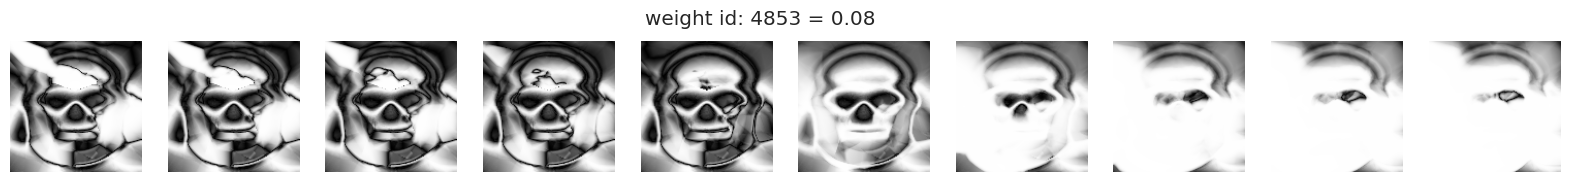

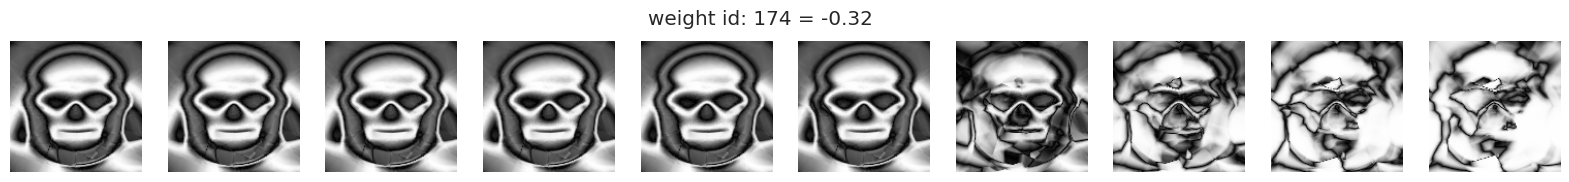

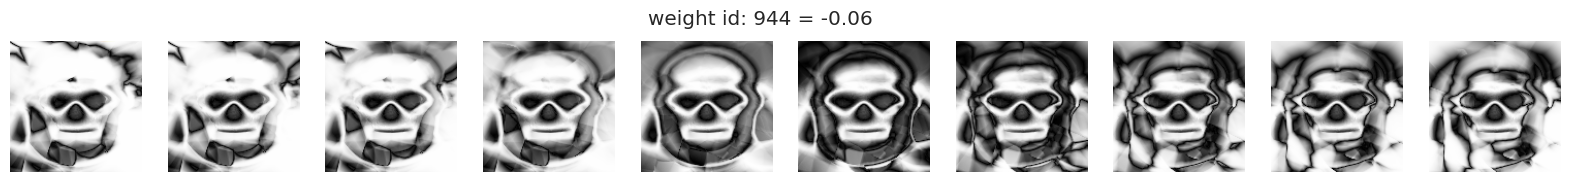

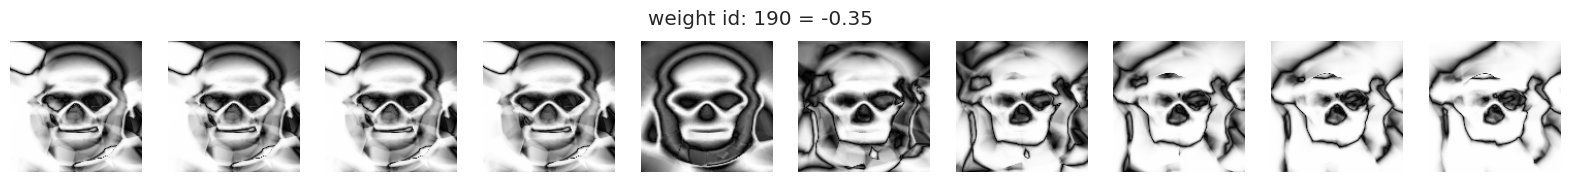

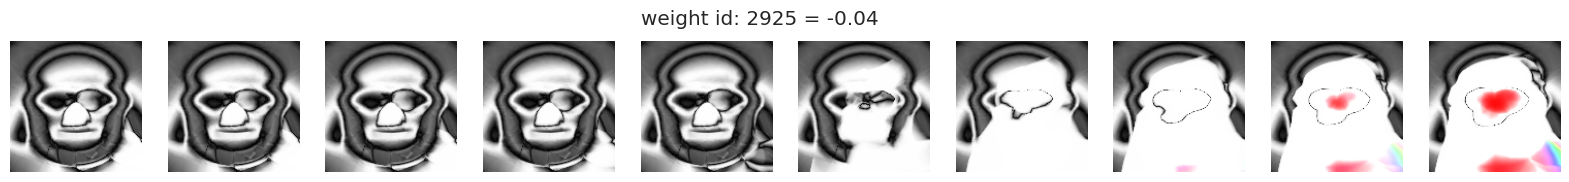

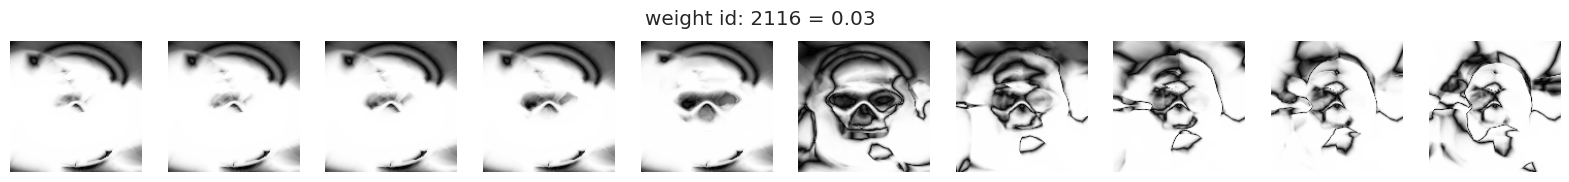

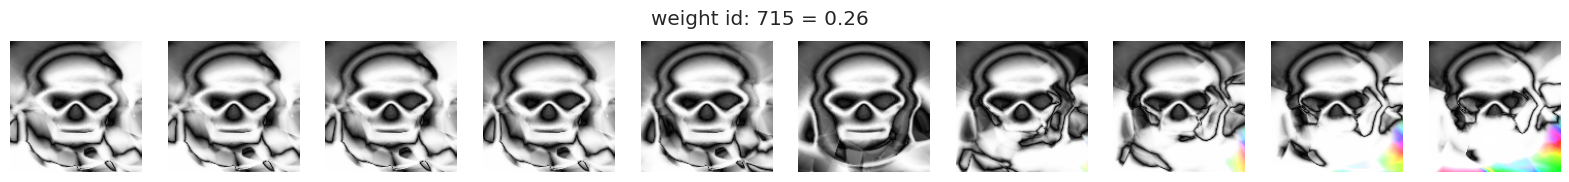

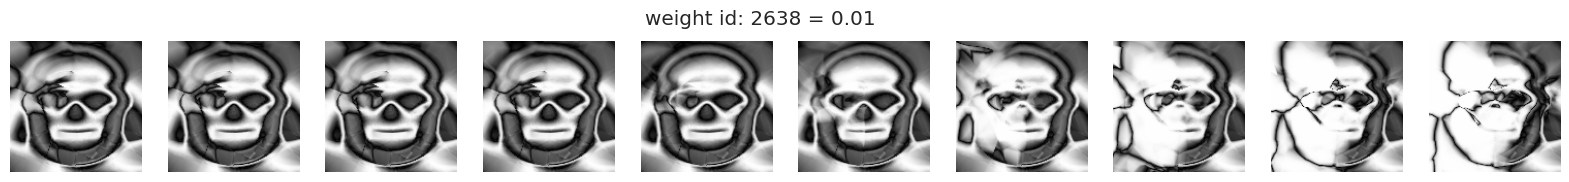

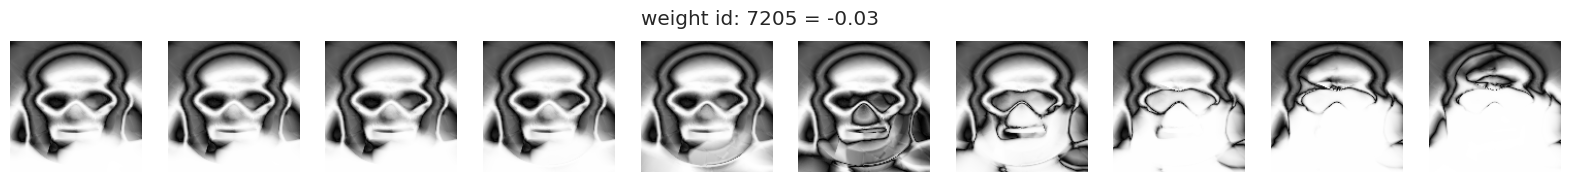

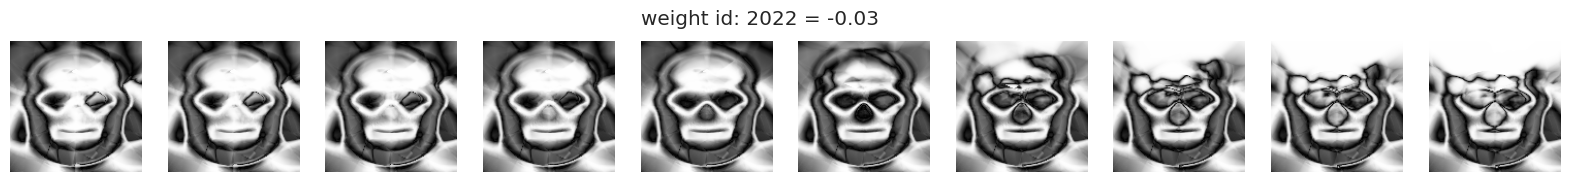

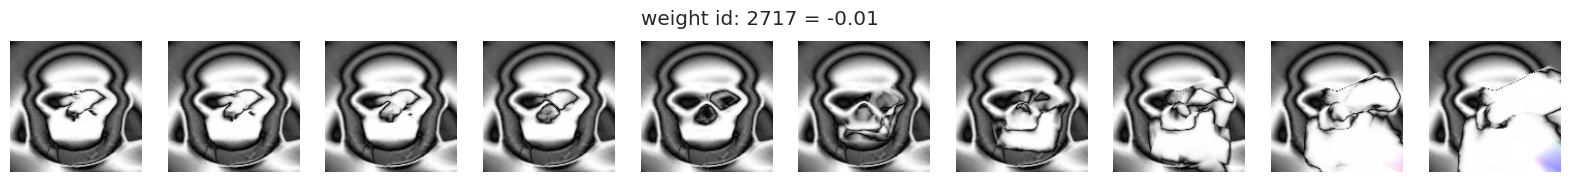

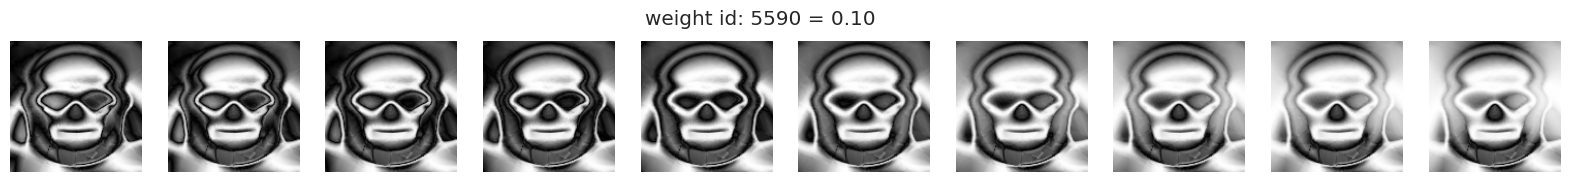

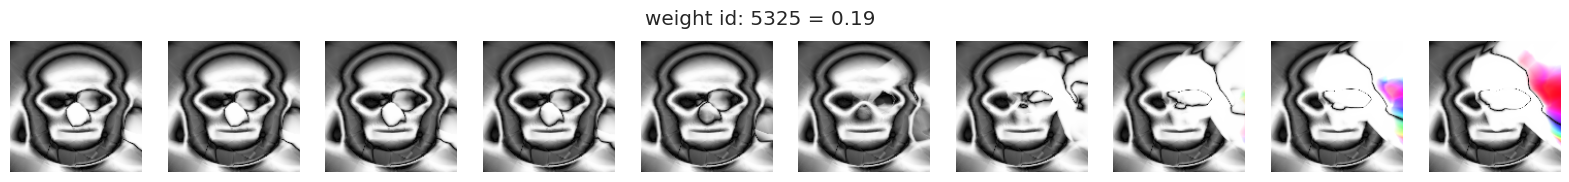

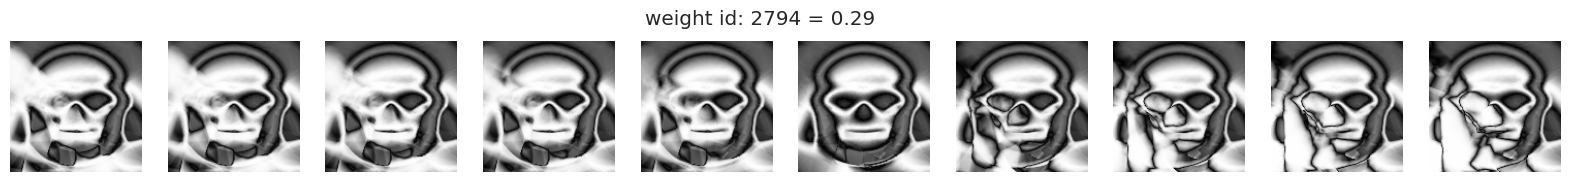

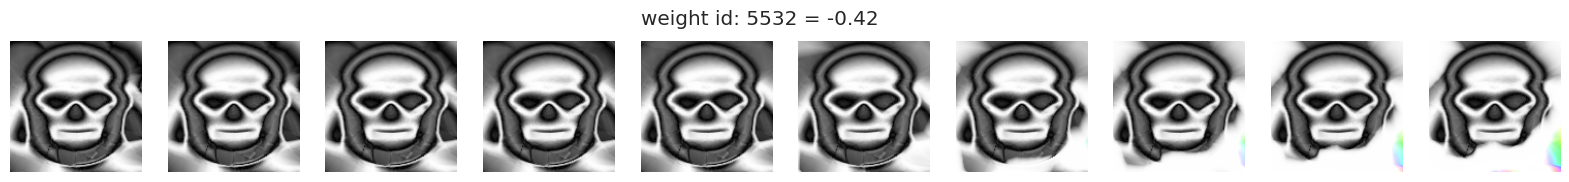

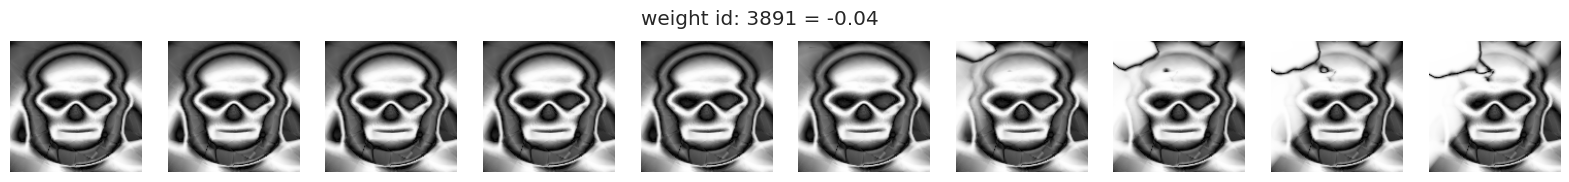

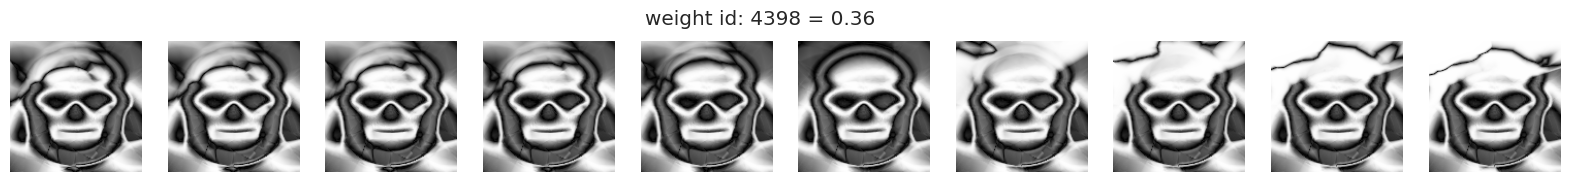

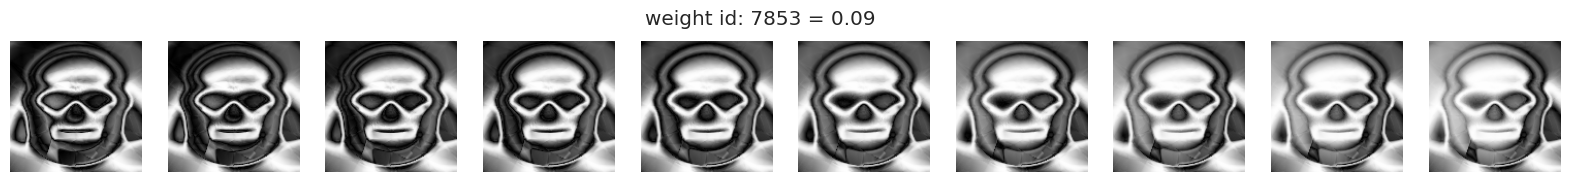

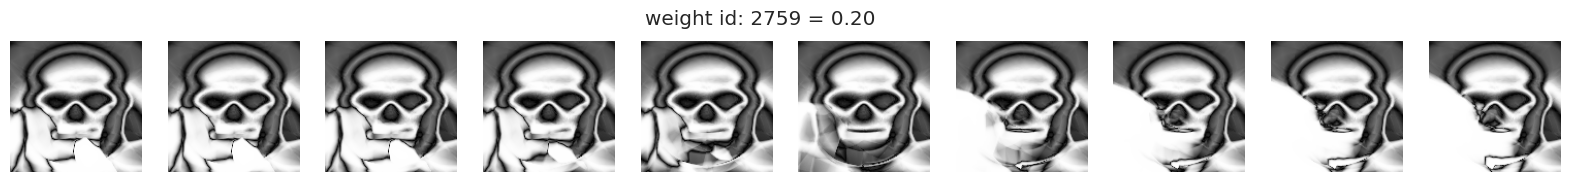

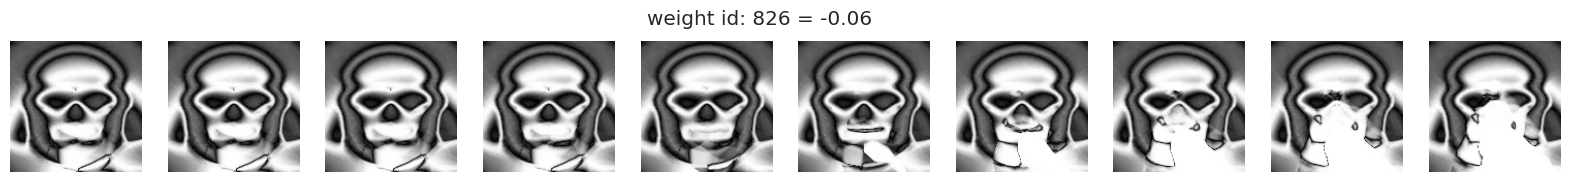

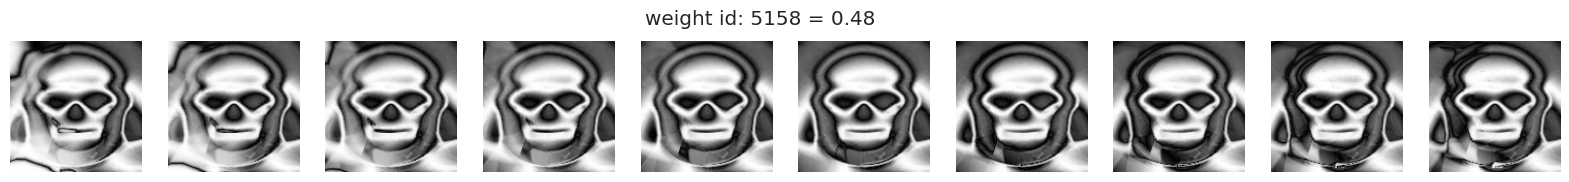

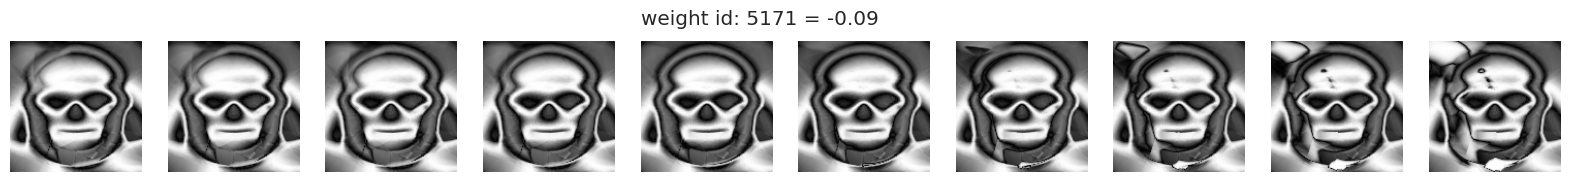

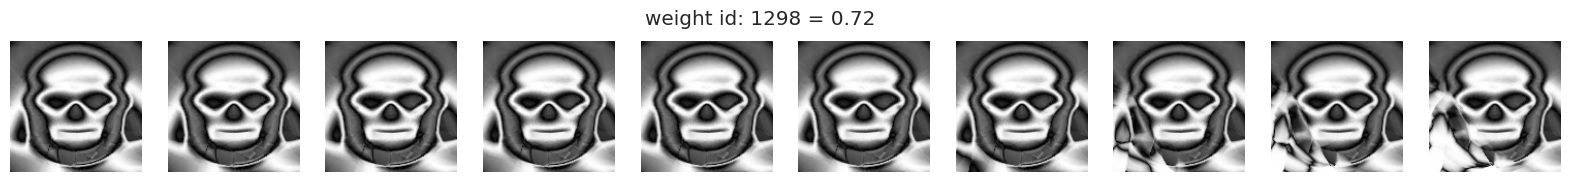

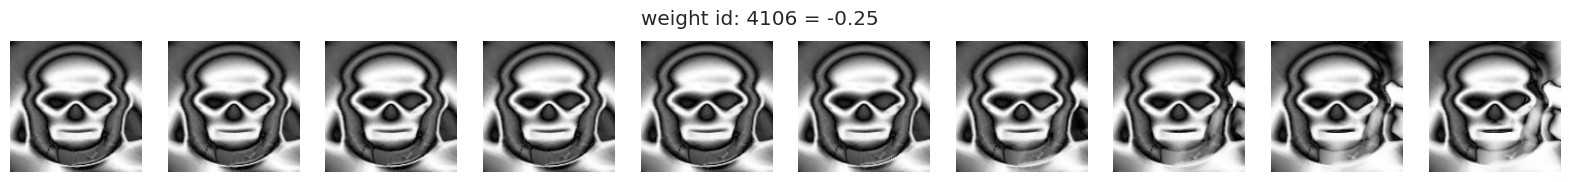

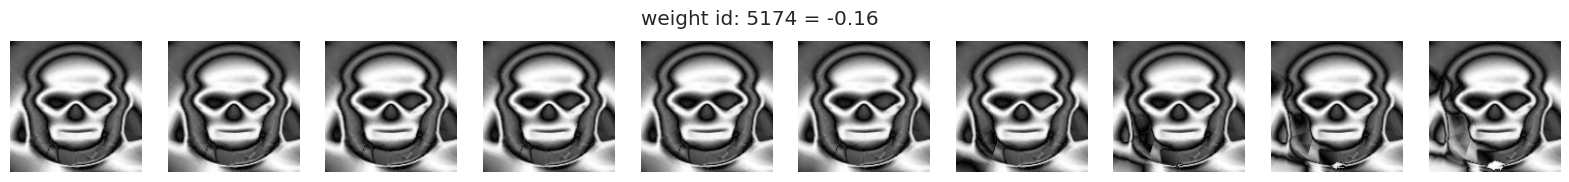

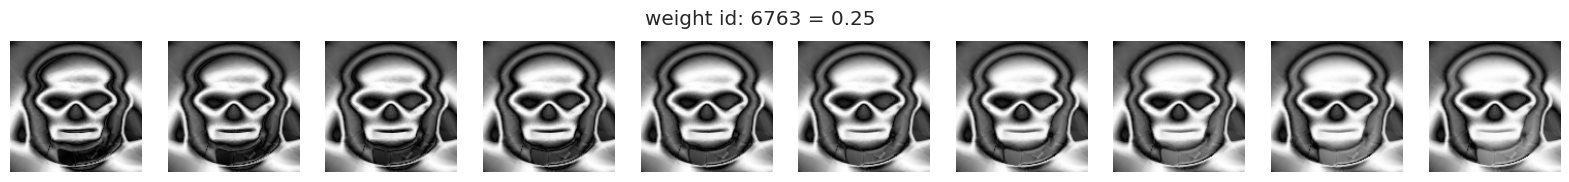

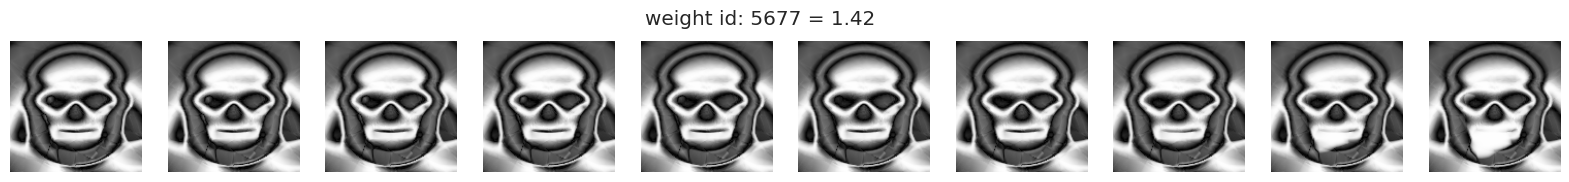

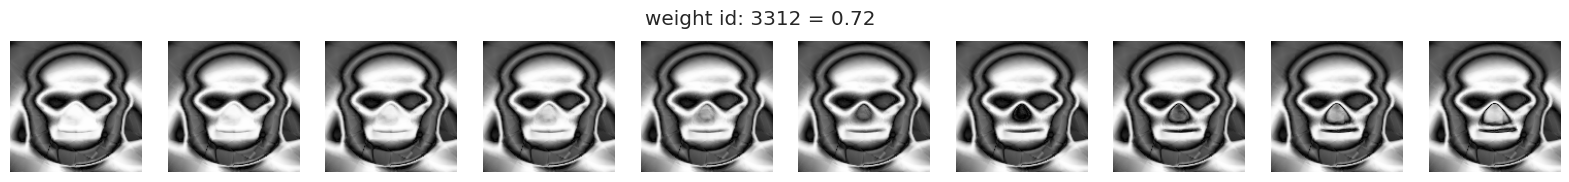

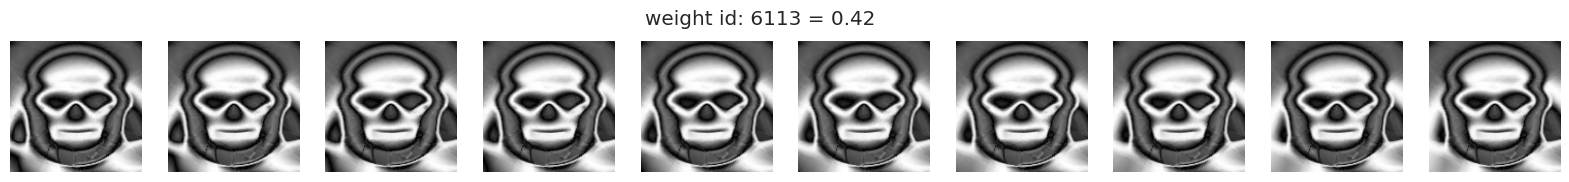

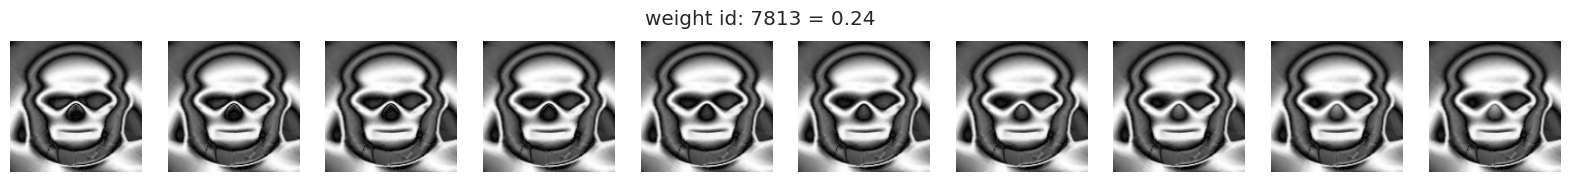

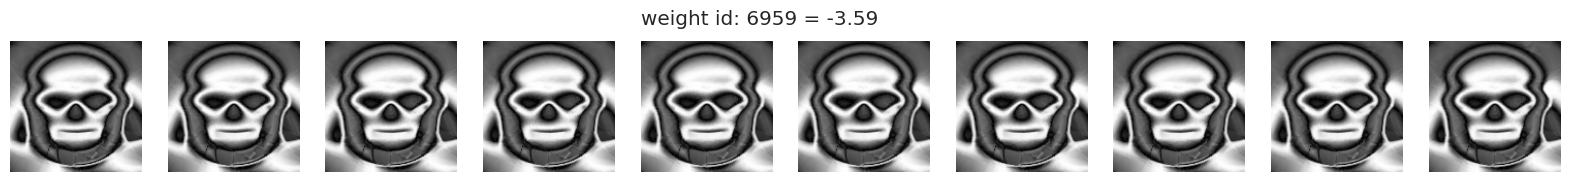

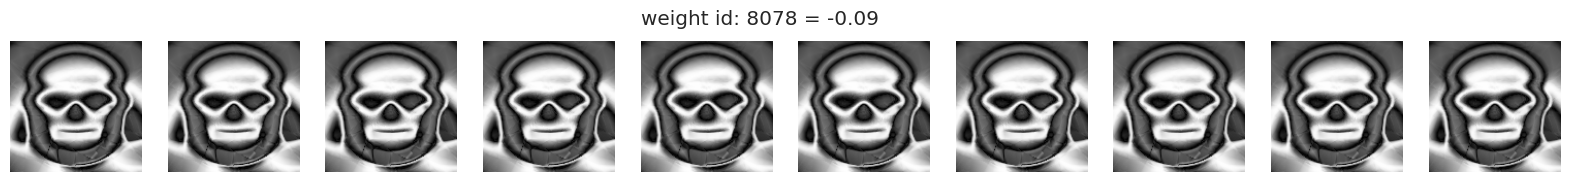

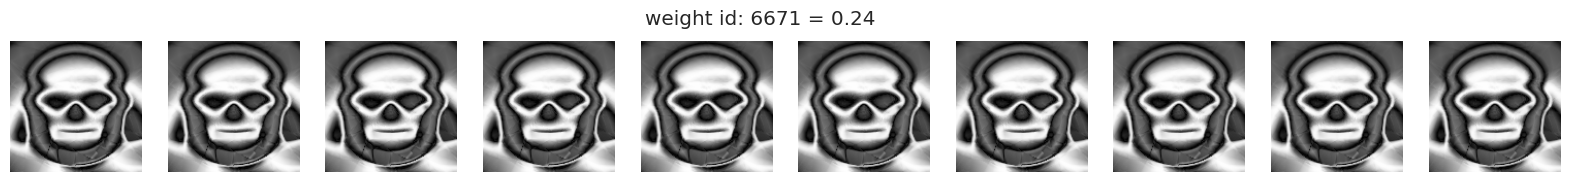

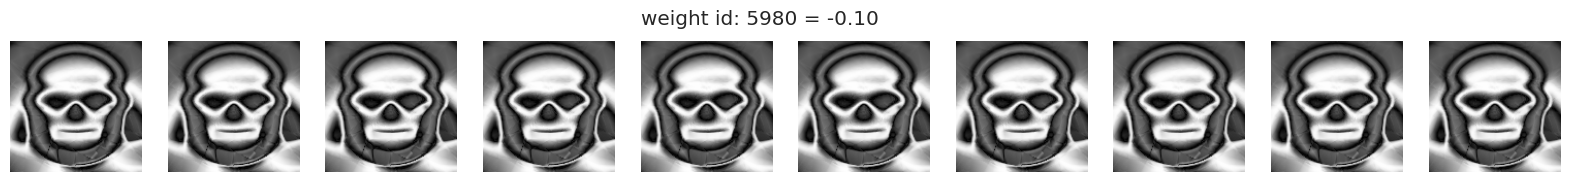

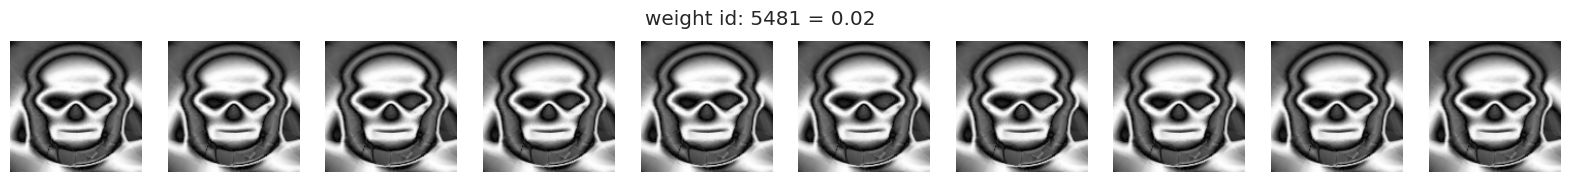

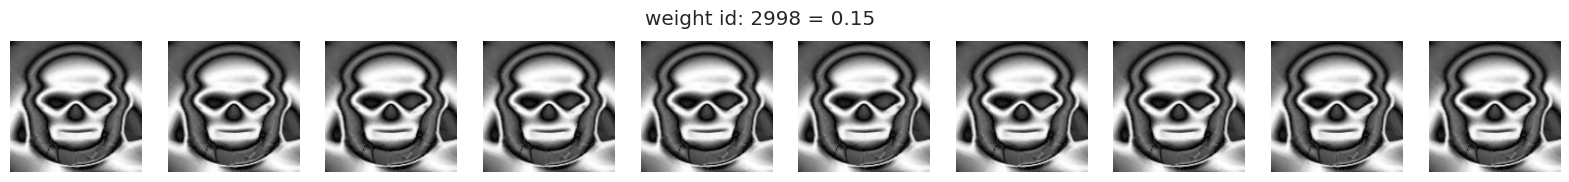

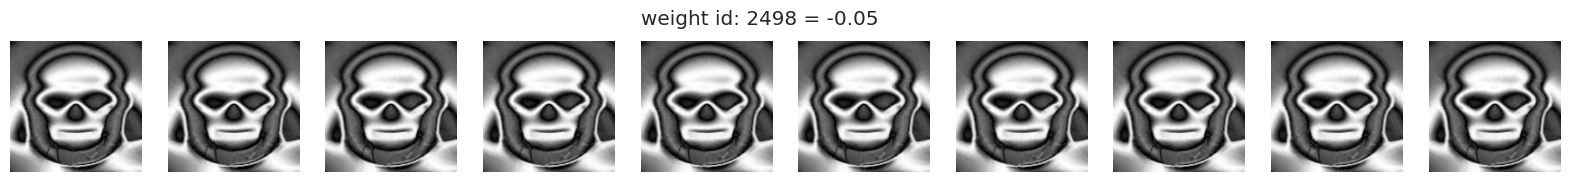

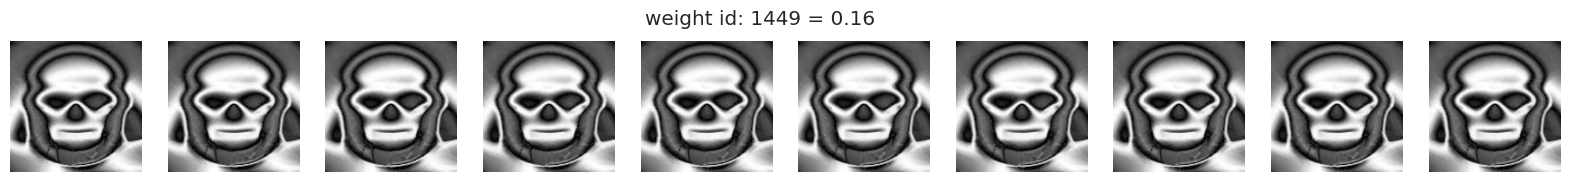

In [66]:
for weight_id in jnp.argsort(variances)[::-1][::200]:
    weight_id = weight_id
    plt.figure(figsize=(20, 2))
    for i, val in enumerate(np.linspace(-3, 3, 10)):
        params_p = params_sgd.at[weight_id].set(val)
        img = cppn.generate_image(params_p)
        plt.subplot(1, 10, i+1); plt.imshow(img); plt.axis('off')
    ori_val = params_sgd[weight_id].item()
    plt.suptitle(f"weight id: {weight_id} = {ori_val:.2f}")
    plt.show()